# 2.1　クラス分類と回帰
- 2クラス分類は、答えがイエス/ノーになる問いに答えるようなもの
- 回帰タスクの目的は連続値の予測

# 2.2 汎化、過剰適合、適合不足
- モデルが未見のデータに対して正確に予想ができるなら、訓練セットを用いてテストセットに対して汎化（generalize）できているという
- 持っている情報の量に比べて過度に複雑なモデルを作ってしまうことを過剰適合（overfitting）という
- に単純すぎるモデルを選択してしまうことを適合不足（underfitting）という
- モデルが複雑になることを許せば許すほど、訓練データに対する予測精度は向上する。しかし、モデルが複雑になりすぎると、訓練セットの個々のデータポイントに重きを置きすぎるようになり、新しいデータに対してうまく汎化できなくなる。このどこかに、最良の汎化性能を示すスイートスポットがある。それが我々の求めるモデル
- アルゴリズムが新しいデータに対してうまく適用できるかどうかを知るにはテストセットを評価するしかない。
## 2.2.1　モデルの複雑さとデータセットの大きさ
- データセットに含まれるデータポイントがバリエーションに富んでいれば、過剰適合を起こすことなく、より複雑なモデルを利用できる。
- 通常は、データポイントが増えればデータのバリエーションも増えるので、データセットが大きくなれば、より複雑なモデルが利用できることになる。- - 同じデータポイントを複製したり、似たようなデータを集めるのではだめ

# 2.3 教師あり機械学習アルゴリズム
- 教師あり学習タスクにおいては、より多くのデータを用い、適度に複雑なモデルを用いると、驚くほどうまくいくことがある。
- 実問題においては、取得するデータの量を決められる場合もあり、モデルを弄り回すよりもデータ量を増やしたほうがよい場合も多い。

## 2.3.1　サンプルデータセット
以下の4つのデータセットを使う．

| |仮想データ|実データ|
|:--:|:--:|:--:|
|クラス分類用|forgeデータセット|cancerデータセット|
|回帰問題用|waveデータセット|boston_housingデータセット|

低次元の仮想データを使うのは可視化が簡単だから．
仮想データに対する直観が高次元データにも適用可能とは限らないので，実データも使ってみる．

In [21]:
"""
仮想データ作成用関数
  mglearn.datasets.make_forge() 
  mglearn.datasets.make_() 
"""
import numbers
import numpy as np
from sklearn.utils import check_array, check_random_state
from sklearn.utils import shuffle as shuffle_

def make_forge():
    # a carefully hand-designed dataset lol
    #X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    random_state=4
    n_samples=30
    n_features=2
    centers=2
    generator = check_random_state(random_state)
    centers = generator.uniform(-10.0, 10.0, size=(centers, n_features))
    X = []
    y = []
    n_centers = centers.shape[0]
    
    n_samples_per_center = [int(n_samples // n_centers)] * n_centers
    cluster_std = np.ones(len(centers))
    for i in range(n_samples % n_centers):
        n_samples_per_center[i] += 1
    for i, (n, std) in enumerate(zip(n_samples_per_center, cluster_std)):
        X.append(centers[i] + generator.normal(scale=std, size=(n, n_features)))
        y += [i] * n
    X = np.concatenate(X)
    y = np.array(y)
    X, y = shuffle_(X, y, random_state=generator)
    
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

def make_wave(n_samples=100):
    rnd = np.random.RandomState(42)
    x = rnd.uniform(-3, 3, size=n_samples)
    y_no_noise = (np.sin(4 * x) + x)
    y = (y_no_noise + rnd.normal(size=len(x))) / 2
    return x.reshape(-1, 1), y

forge データセットの生成

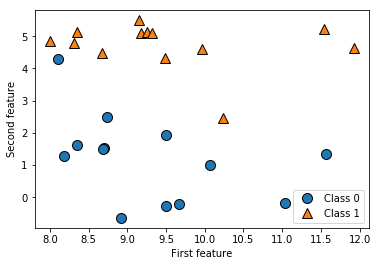

In [22]:
# データセットの生成
X, y = make_forge()
# データセットをプロット
# ここから discrete_scatter
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter
ax = plt.gca()
unique_y = np.unique(y)
markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10 
labels = unique_y
current_cycler = mpl.rcParams['axes.prop_cycle']
lines = []
for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
    mask = y == yy
    color = cycle['color'] # use color cycle
    if np.mean(colorConverter.to_rgb(color)) < .4:
        markeredgecolor = "grey"
    else:
        markeredgecolor = "black"
    lines.append(ax.plot(X[mask, 0], X[mask, 1], markers[i], markersize=10, label=labels[i], alpha=1, c=color,
                         markeredgecolor=markeredgecolor)[0])
# ここまで discrete_scatter
plt.legend(["Class 0", "Class 1"], loc=4)
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()

wave データセットの作成

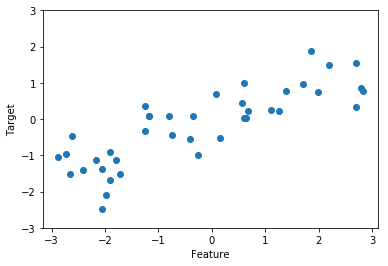

In [23]:
# データセットの生成
X, y = make_wave(n_samples=40)
# データのプロット
plt.plot(X, y, 'o')
plt.ylim(-3,3)
plt.xlabel("Feature")
plt.ylabel("Target")
plt.show()

cancerデータセット
scikit-learnにあるデータを使用

In [25]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
cancer.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [26]:
cancer.data.shape

(569, 30)

In [29]:
{n: v for n, v in zip(cancer.target_names, np.bincount(cancer.target))}

{'benign': 357, 'malignant': 212}

In [30]:
cancer.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='<U23')

boston_housingデータセット
こちらのscikit-learnのデータセットを使用

In [31]:
from sklearn.datasets import load_boston
boston = load_boston()
boston.data.shape

(506, 13)

In [35]:
# load_extended_boston() 関数の内容
from sklearn.preprocessing import MinMaxScaler,  PolynomialFeatures
X = boston.data
X = MinMaxScaler().fit_transform(boston.data)
X = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X)
X.shape

(506, 104)